# DeepPurpose Deep Dive
## Tutorial 2: Training a Drug Property Prediction Model from Scratch for Assay Data
#### [@KexinHuang5](https://twitter.com/KexinHuang5)

In this tutorial, we further extends the use cases of DeepPurpose to assay data where there are only drug information and its affinity score to the protein in the assay. 

Agenda:

- Part I: Introduction to Assay Data
- Part II: Drug Property Prediction

Let's start!

In [1]:
from DeepPurpose import utils, dataset, CompoundPred
import warnings
warnings.filterwarnings("ignore")

## Part I: Introduction to Assay Data

Drug-target interaction measures the binding of drug molecules to the protein targets. In drug discovery process, we usually already have a protein of interest and traditionally, high-throughput screening assay is performed on a potential drug library to get affinity scores. But it is expensive and time-consuming, and it cannot go through a huge amount of molecule candidates, which means it potentially can miss a drug candidate. Machine learning can provide an important role to facilitate this process. One way to do it is to narrow down the search space for HTS. Here are the steps:

1. For a target protein of interest, conduct an initial high-throughput screening assay on a set of drugs (ideally, structurally diverse), where the set size depends on the time and cost constraint.

2. Train a deep learning model using DeepPurpose and select a threshold to control the false positive rate (e.g., < 0.02).

3. Apply the trained model on a large set of drugs. Select the set of drugs that meet the threshold and send to HTS.

Through the above three steps, it greatly cuts down the time of screening and also reduces the likelihood of missing a potential drug candidate. Now, we show the step 2: using DeepPurpose to train a deep learning model for screening the assay. 

(**Data**) DeepPurpose takes into an array of drug's SMILES strings (**d**) and an array of label (**y**), which can either be binary 0/1 indicating interaction outcome or a real number indicating affinity value. Note **y**\[0\] is the score for **d**\[0\].

Besides transforming into numpy arrays through some data wrangling on your own, DeepPurpose also provides two ways to help data preparation. 

The first way is to read from local files. For example, to load drug assay data, we expect a file.txt where each line is a drug SMILES string, followed by an affinity score or 0/1 label:

```CC1=C...C4)N  7.365```

Then, we use ```dataset.read_file_training_dataset_bioassay``` to load it.

In [2]:
X_drugs, X_targets, y = dataset.read_file_training_dataset_bioassay('./toy_data/AID1706.txt')
print('Drug 1: ' + X_drugs[0])
print('Score 1: ' + str(y[0]))

Drug 1: CCOC1=CC=C(C=C1)N2C=CC(=O)C(=N2)C(=O)NC3=CC=C(C=C3)S(=O)(=O)NC4=NC=CC=N4
Score 1: 0.0


DeepPurpose also provides data loaders to ease preprocessing. For example, in this tutorial, we will use the HIV screening data. We can use ```dataset.load_HIV```. It will download, preprocess to the designated data format. 

In [3]:
X_drugs, y, drugs_index = dataset.load_HIV(path = './data')
print('Drug 1: ' + X_drugs[0])
print('Score 1: ' + str(y[0]))

Dataset already downloaded in the local system...


Drug 1: CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
Score 1: 0


For more detailed examples and tutorials of data loading, checkout this [tutorial](./DEMO/load_data_tutorial.ipynb).

## Part II: Drug Property Prediction Framework

DeepPurpose provides a simple framework to do drug property prediction research using 8 encoders for drugs. It basically consists of the following steps, where each step corresponds to one line of code:

- Encoder specification
- Data encoding and split
- Model configuration generation
- Model initialization
- Model Training
- Model Prediction and Repuposing/Screening
- Model Saving and Loading

Let's start with data encoding! 

(**Encoder specification**) After we obtain the required data format from Part I, we need to prepare them for the encoders. Hence, we first specify the encoder to use for drug and protein. Here we try MPNN for drug.

If you find MPNN is too large for the CPUs, you can try smaller encoders by uncommenting the last line:

In [4]:
#drug_encoding = 'MPNN'
drug_encoding = 'Morgan'

Note that you can switch encoder just by changing the encoding name above. The full list of encoders are listed [here](https://github.com/kexinhuang12345/DeepPurpose#encodings). 

(**Data encoding and split**) Now, we encode the data into the specified format, using ```utils.data_process``` function. It specifies train/validation/test split fractions, and random seed to ensure same data splits for reproducibility. This function also support data splitting methods such as ```cold_drug```, which splits on drug for model robustness evaluation to test on unseen drug/proteins.

The function outputs train, val, test pandas dataframes.

In [5]:
train, val, test = utils.data_process(X_drug = X_drugs, y = y, drug_encoding = drug_encoding,
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)
train.head(1)

Drug Property Prediction Mode...
in total: 41127 drugs
encoding drug...
unique drugs: 41127


RDKit WARNING: [09:01:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [09:01:53] WARNING: not removing hydrogen atom without neighbors


Done.


,SMILES,Label,drug_encoding
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
import numpy as np
np.unique(y)

array([0, 1])

(**Model configuration generation**) Now, we initialize a model with its configuration. You can modify almost any hyper-parameters (e.g., learning rate, epoch, batch size), model parameters (e.g. hidden dimensions, filter size) and etc in this function. The supported configurations are listed here in this [link](https://github.com/kexinhuang12345/DeepPurpose/blob/e169e2f550694145077bb2af95a4031abe400a77/DeepPurpose/utils.py#L486).

For the sake of example, we specify the epoch size to be 3, and set the model parameters to be small so that you can run on both CPUs & GPUs quickly and can proceed to the next steps. For a reference parameters, checkout the notebooks in the DEMO folder.

In [7]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 3, 
                         LR = 0.001, 
                         batch_size = 128,
                         hidden_dim_drug = 128,
                         mpnn_hidden_size = 128,
                         mpnn_depth = 3
                        )

(**Model initialization**) Next, we initialize a model using the above configuration.

In [8]:
model = CompoundPred.model_initialize(**config)
model

(**Model Training**) Next, it is ready to train, using the ```model.train``` function! If you do not have test set, you can just use ```model.train(train, val)```. 

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69454. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.11414. Total time 0.00138 hours
Training at Epoch 1 iteration 200 with loss 0.17790. Total time 0.0025 hours
Validation at Epoch 1 , AUROC: 0.78535 , AUPRC: 0.38694 , F1: 0.37810
Training at Epoch 2 iteration 0 with loss 0.11183. Total time 0.00333 hours
Training at Epoch 2 iteration 100 with loss 0.10962. Total time 0.00472 hours
Training at Epoch 2 iteration 200 with loss 0.11443. Total time 0.00611 hours
Validation at Epoch 2 , AUROC: 0.82523 , AUPRC: 0.47837 , F1: 0.46601
Training at Epoch 3 iteration 0 with loss 0.08445. Total time 0.00666 hours
Training at Epoch 3 iteration 100 with loss 0.14978. Total time 0.00805 hours
Training at Epoch 3 iteration 200 with loss 0.11269. Total time 0.00944 hours
Validation at Epoch 3 , AUROC: 0.84940 , AUPRC: 0.52009 , F1: 0.45989
--- Go for Testing ---
Testing AU

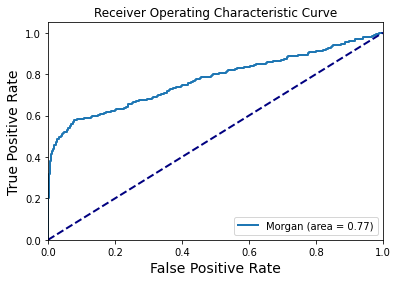

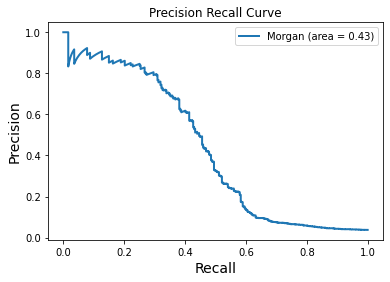

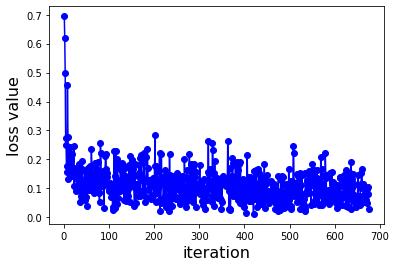

In [9]:
model.train(train, val, test)

We see that the model will automatically generate and plot the training process, along with the validation result and test result.

(**Model Prediction and Repuposing/Screening**) Next, we see how we can predict affinity scores on new data. Suppose the new data is a new drug below.

In [10]:
X_drug = ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_pred = utils.data_process(X_drug = X_drug, y = y, drug_encoding = drug_encoding, split_method='no_split')
y_pred = model.predict(X_pred)
print('The predicted score is ' + str(y_pred))

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The predicted score is [0.003792080795392394]


We can also do repurposing/screening using the trained model. Basically, for repurposing/screening a set of new drugs (**r**), we run the above prediction function. We wrap the operation into a ```models.repurpose```.

For example, suppose we want to do repurposing from a set of antiviral drugs for the COVID-19 target 3CL protease. The corresponding data can be retrieved using ```dataset``` functions.


In [11]:
r, r_name, r_pubchem_cid = dataset.load_antiviral_drugs()
print('Repurposing Drug 1 Name: ' + r_name[0])
print('Repurposing Drug 1 SMILES: ' + r[0])
print('Repurposing Drug 1 Pubchem CID: ' + str(r_pubchem_cid[0]))

Repurposing Drug 1 Name: Abacavir
Repurposing Drug 1 SMILES: C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO
Repurposing Drug 1 Pubchem CID: 441300


Now, we can call the ```repurpose``` function. After feeding the necessary inputs, it will print a list of repurposed drugs ranked on its affinity to the target protein. The ```convert_y``` parameter should be set to be ```False``` when the ranking is ascending (i.e. lower value -> higher affinity) due to the log transformation, vice versus.

In [12]:
y_pred = CompoundPred.repurpose(X_repurpose = r, model = model, drug_names = r_name)

repurposing...
Drug Property Prediction Mode...
in total: 82 drugs
encoding drug...
unique drugs: 81
Done.
predicting...
---------------
Drug Repurposing Result
+------+----------------------+-------------+-------------+
| Rank |      Drug Name       | Interaction | Probability |
+------+----------------------+-------------+-------------+
|  1   |      Zidovudine      |     YES     |     0.82    |
|  2   |      Stavudine       |      NO     |     0.49    |
|  3   |     Zalcitabine      |      NO     |     0.39    |
|  4   |      Didanosine      |      NO     |     0.20    |
|  5   |      Nevirapine      |      NO     |     0.19    |
|  6   |    Fosamprenavir     |      NO     |     0.17    |
|  7   |      Amprenavir      |      NO     |     0.10    |
|  8   |      Pyrimidine      |      NO     |     0.07    |
|  9   |    Emtricitabine     |      NO     |     0.06    |
|  10  |     Tromantadine     |      NO     |     0.03    |
checkout ./result/repurposing.txt for the whole list


Saving and loading models are also really easy. The loading function also automatically detects if the model is trained on multiple GPUs. To save a model:

In [13]:
model.save_model('./tutorial_model')

To load a saved/pretrained model:

In [14]:
model = CompoundPred.model_pretrained(path_dir = './tutorial_model')
model

We also provided more functionalities for DTI research purposes. 

For example, this [demo](https://github.com/kexinhuang12345/DeepPurpose/blob/master/DEMO/Drug_Property_Pred-Ax-Hyperparam-Tune.ipynb) shows how to use Ax platform to do some latest hyperparameter tuning methods such as Bayesian Optimization on DeepPurpose.

They are described in details in tutorial 1 and in the github repository.

That wraps up our tutorials on the main functionalities of DeepPurpose's Drug Property Prediction framework! 

Do checkout the previous & upcoming tutorials:

Tutorial 1: Training a Drug-Target Interaction Model from Scratch

Tutorial 3: Repurposing and Virtual Screening Using One Line of Code

**Star & watch & contribute to DeepPurpose's [github repository](https://github.com/kexinhuang12345/DeepPurpose)!**

Feedbacks would also be appreciated and you can send me an email (kexinhuang@hsph.harvard.edu)!